In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [79]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#def load_data(train_data, test_data, num_words=num_words):
def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", ""] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [80]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [98]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[0:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [99]:
# 데이터 검증
print(train_data["document"][0], X_train[0])
get_decoded_sentence(X_train[0], index_to_word)

아 더빙.. 진짜 짜증나네요 목소리 [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


'아 더 빙 . . 진짜 짜증 나 네요 목소리'

In [102]:
# 데이터 검증을 위해 인코딩 과정에 디버깅 출력 포함
def get_encoded_sentence_debug(sentence, word_to_index):
    print(sentence)
    word_vec = []
    for word in sentence.split():
        print(word)
        if word in word_to_index:
            print(word_to_index[word])
            word_vec.append(word_to_index[word])
        else:
            print(word_to_index['<UNK>'])
            word_vec.append(word_to_index['<UNK>'])
               
    return [word_to_index['<BOS>']]+word_vec


get_encoded_sentence_debug(train_data["document"][0], word_to_index)

아 더빙.. 진짜 짜증나네요 목소리
아
32
더빙..
2
진짜
39
짜증나네요
2
목소리
748


[1, 32, 2, 39, 2, 748]

In [89]:
# 문장 길이 계산
X_len = [len(word_vec) for word_vec in X_train]

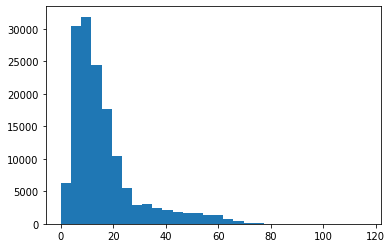

In [100]:
import matplotlib.pyplot as plt

# X_len에 대한 히스토그램 -> bins 수를 알 수 없어서 정확한 그림을 그리기 어려움
plt.hist(X_len, bins=30)
plt.show()

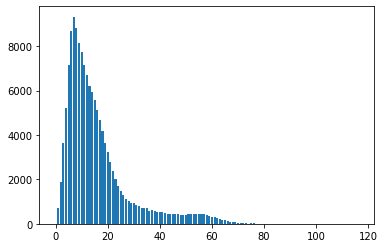

In [101]:
# 카운터를 계산하고 bar 그래프로 표현
X_len_counter = Counter(X_len)
#print(X_len_counter)

plt.bar(X_len_counter.keys(), X_len_counter.values())
plt.show()

In [108]:
import tensorflow as tf

# 문장 최대 길이
max_len = 40

# 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=max_len)

print(X_train[0], len(X_train[0]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4  39
 228  20  33 748] 40


In [110]:
# 모델 구성1 - LSTM
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(10000, max_len, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(32))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                9344      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 409,377
Trainable params: 409,377
Non-trainable params: 0
_________________________________________________________________


In [115]:
# 데이터셋 분리
print(X_train.shape)

# Validation Set 20000건
validation_size = 20000
X_val = X_train[:validation_size]   
y_val = y_train[:validation_size]

# Train Set 조정
partial_X_train = X_train[validation_size:]  
partial_y_train = y_train[validation_size:]

print(partial_X_train.shape, partial_y_train.shape, X_val.shape, y_val.shape)

(146182, 40)
(126182, 40) (126182,) (20000, 40) (20000,)


In [131]:
# 학습
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=50
lstm_history = lstm_model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/50
247/247 [==============================] - 3s 7ms/step - loss: 0.0413 - accuracy: 0.9844 - val_loss: 0.5219 - val_accuracy: 0.8903
Epoch 2/50
247/247 [==============================] - 1s 5ms/step - loss: 0.0338 - accuracy: 0.9876 - val_loss: 0.5517 - val_accuracy: 0.8912
Epoch 3/50
247/247 [==============================] - 1s 5ms/step - loss: 0.0363 - accuracy: 0.9865 - val_loss: 0.5740 - val_accuracy: 0.8878
Epoch 4/50
247/247 [==============================] - 1s 5ms/step - loss: 0.0358 - accuracy: 0.9870 - val_loss: 0.5920 - val_accuracy: 0.8862
Epoch 5/50
247/247 [==============================] - 1s 5ms/step - loss: 0.0323 - accuracy: 0.9883 - val_loss: 0.5777 - val_accuracy: 0.8884
Epoch 6/50
247/247 [==============================] - 1s 5ms/step - loss: 0.0318 - accuracy: 0.9886 - val_loss: 0.5954 - val_accuracy: 0.8860
Epoch 7/50
247/247 [==============================] - 1s 5ms/step - loss: 0.0296 - accuracy: 0.9892 - val_loss: 0.6499 - val_accuracy: 0.8842
Epoch 

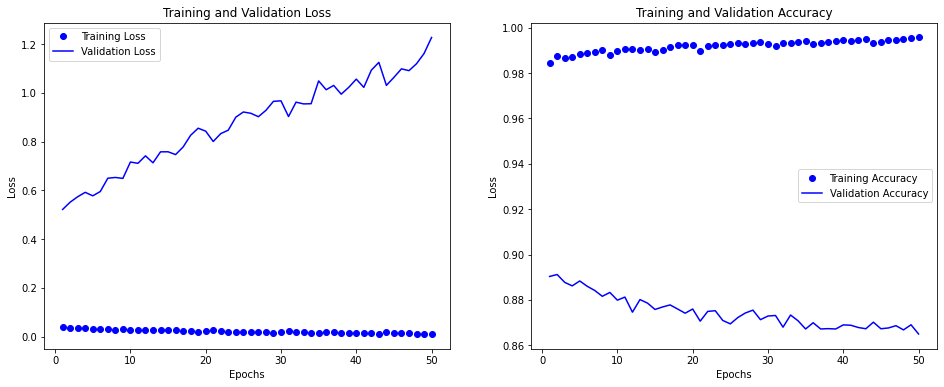

In [132]:
# 시각화
import matplotlib.pyplot as plt

acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 학습이 진행될 수록 Train Set에 대한 accuracy는 증가하나, Validation Set에 대한 Accuracy는 감소
- Loss 역시 학습이 진행될 수록 Validation Set의 경우 지속적으로 증가하는 형태

In [119]:
# 모델 2 - 심플 LSTM, 임베딩층 제거
inputs = tf.keras.Input(shape=(max_len, 1))
x = tf.keras.layers.LSTM(64)(inputs)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

lstm_model2 = tf.keras.Model(inputs, outputs)

lstm_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 1)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [123]:
lstm_model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model2_history = lstm_model2.fit(partial_X_train, partial_y_train, epochs=50, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/50
247/247 [==============================] - 3s 6ms/step - loss: 0.6625 - accuracy: 0.5963 - val_loss: 0.6613 - val_accuracy: 0.5989
Epoch 2/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6614 - accuracy: 0.5977 - val_loss: 0.6606 - val_accuracy: 0.5992
Epoch 3/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6606 - accuracy: 0.5994 - val_loss: 0.6593 - val_accuracy: 0.6003
Epoch 4/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6593 - accuracy: 0.6005 - val_loss: 0.6590 - val_accuracy: 0.6011
Epoch 5/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6595 - accuracy: 0.5999 - val_loss: 0.6581 - val_accuracy: 0.6019
Epoch 6/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6576 - accuracy: 0.6024 - val_loss: 0.6568 - val_accuracy: 0.6019
Epoch 7/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6564 - accuracy: 0.6041 - val_loss: 0.6579 - val_accuracy: 0.6004
Epoch 

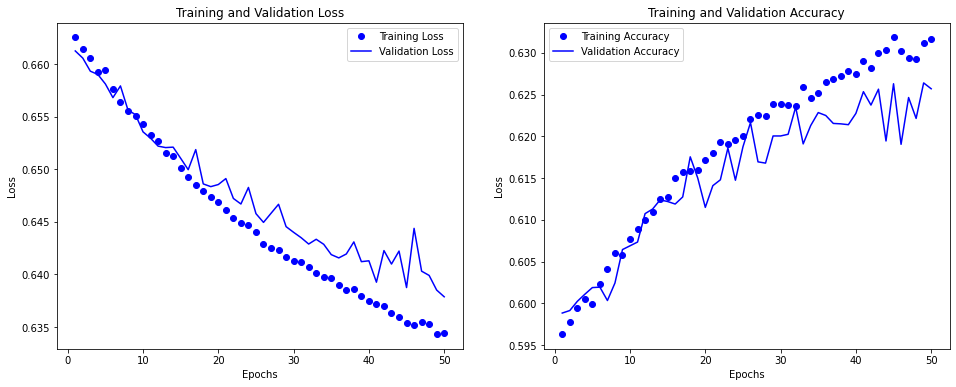

In [130]:
# 시각화
import matplotlib.pyplot as plt

acc2 = lstm_model2_history.history['accuracy']
val_acc2 = lstm_model2_history.history['val_accuracy']
loss2 = lstm_model2_history.history['loss']
val_loss2 = lstm_model2_history.history['val_loss']

epochs = range(1, len(acc2) + 1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss2, 'bo', label='Training Loss')
plt.plot(epochs, val_loss2, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 학습이 진행될 수록 Train Set, Validation Set의 Loss 모두 감소하는 형태. Accuracy도 둘 다 증가하나 60% 범위에서 증가하지 않음

In [133]:
# Learning Rate 변경
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
lstm_model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
lstm_model2_history = lstm_model2.fit(partial_X_train, partial_y_train, epochs=50, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/50
247/247 [==============================] - 3s 6ms/step - loss: 0.6642 - accuracy: 0.5973 - val_loss: 0.6562 - val_accuracy: 0.6047
Epoch 2/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6566 - accuracy: 0.6048 - val_loss: 0.6535 - val_accuracy: 0.6098
Epoch 3/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6535 - accuracy: 0.6082 - val_loss: 0.6577 - val_accuracy: 0.6037
Epoch 4/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6481 - accuracy: 0.6153 - val_loss: 0.6457 - val_accuracy: 0.6159
Epoch 5/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6467 - accuracy: 0.6172 - val_loss: 0.6460 - val_accuracy: 0.6177
Epoch 6/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6450 - accuracy: 0.6175 - val_loss: 0.6539 - val_accuracy: 0.6104
Epoch 7/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6433 - accuracy: 0.6194 - val_loss: 0.6408 - val_accuracy: 0.6223
Epoch 

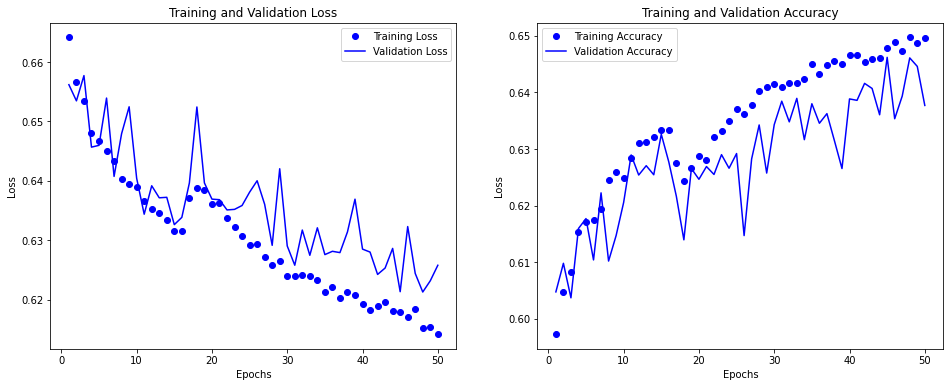

In [134]:
# 시각화
import matplotlib.pyplot as plt

acc2 = lstm_model2_history.history['accuracy']
val_acc2 = lstm_model2_history.history['val_accuracy']
loss2 = lstm_model2_history.history['loss']
val_loss2 = lstm_model2_history.history['val_loss']

epochs = range(1, len(acc2) + 1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss2, 'bo', label='Training Loss')
plt.plot(epochs, val_loss2, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- Learning Rate: 0.01 (디폴트값은 0.001)
- 변화의 양상은 동일. 변화의 폭은 더 커짐

In [135]:
# Learning Rate 변경
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
lstm_model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
lstm_model2_history = lstm_model2.fit(partial_X_train, partial_y_train, epochs=50, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/50
247/247 [==============================] - 3s 6ms/step - loss: 0.6927 - accuracy: 0.5393 - val_loss: 0.6807 - val_accuracy: 0.5548
Epoch 2/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6821 - accuracy: 0.5533 - val_loss: 0.6809 - val_accuracy: 0.5531
Epoch 3/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6837 - accuracy: 0.5494 - val_loss: 0.6863 - val_accuracy: 0.5440
Epoch 4/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6848 - accuracy: 0.5456 - val_loss: 0.6792 - val_accuracy: 0.5526
Epoch 5/50
247/247 [==============================] - 1s 5ms/step - loss: 0.6847 - accuracy: 0.5468 - val_loss: 0.6903 - val_accuracy: 0.5364
Epoch 6/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6809 - accuracy: 0.5492 - val_loss: 0.6856 - val_accuracy: 0.5461
Epoch 7/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6813 - accuracy: 0.5507 - val_loss: 0.6792 - val_accuracy: 0.5497
Epoch 

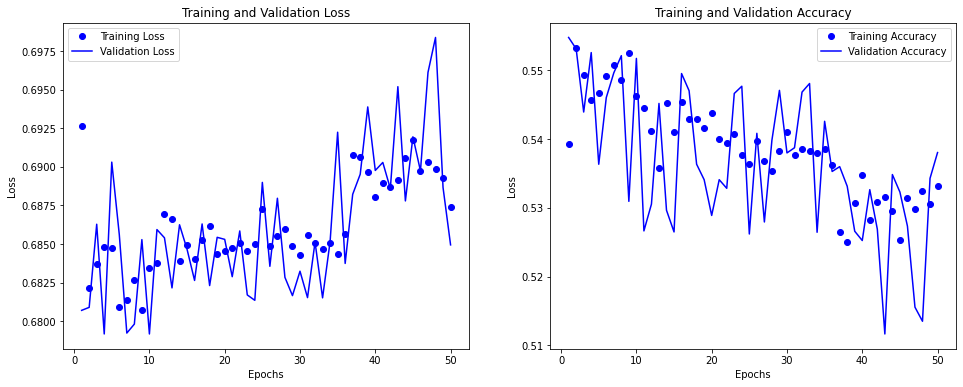

In [136]:
# 시각화
import matplotlib.pyplot as plt

acc2 = lstm_model2_history.history['accuracy']
val_acc2 = lstm_model2_history.history['val_accuracy']
loss2 = lstm_model2_history.history['loss']
val_loss2 = lstm_model2_history.history['val_loss']

epochs = range(1, len(acc2) + 1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss2, 'bo', label='Training Loss')
plt.plot(epochs, val_loss2, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- Learning Rate: 0.1
- 성능은 더 안 좋아지고, Loss, Accuracy의 변화의 폭이 커짐

In [137]:
# Test Set 성능 표시
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
lstm_model2_history = lstm_model2.fit(partial_X_train, partial_y_train, epochs=50, batch_size=512, validation_data=(X_val, y_val))

result = lstm_model2.evaluate(X_test, y_test)

Epoch 1/50
247/247 [==============================] - 3s 6ms/step - loss: 0.6841 - accuracy: 0.5401 - val_loss: 0.6845 - val_accuracy: 0.5408
Epoch 2/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6838 - accuracy: 0.5424 - val_loss: 0.6843 - val_accuracy: 0.5442
Epoch 3/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6837 - accuracy: 0.5435 - val_loss: 0.6842 - val_accuracy: 0.5409
Epoch 4/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6836 - accuracy: 0.5424 - val_loss: 0.6842 - val_accuracy: 0.5442
Epoch 5/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6836 - accuracy: 0.5428 - val_loss: 0.6842 - val_accuracy: 0.5414
Epoch 6/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6836 - accuracy: 0.5429 - val_loss: 0.6842 - val_accuracy: 0.5441
Epoch 7/50
247/247 [==============================] - 1s 4ms/step - loss: 0.6836 - accuracy: 0.5441 - val_loss: 0.6841 - val_accuracy: 0.5429
Epoch 

In [139]:
# Mode 1의 테스트셋 성능

result = lstm_model.evaluate(X_test, y_test)
print(result)

1537/1537 [==============================] - 4s 2ms/step - loss: 1.8418 - accuracy: 0.8262
[1.8417611122131348, 0.8261895775794983]


In [141]:
# 한글 word vector 모델 가져오기
word2vec_file_path = "/aiffel/data/word2vec_ko.model"

from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["끝"]

print(vector)

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   

In [155]:
# 데이터 읽어오기

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any')
train_data.replace(to_replace=r'[.]', value=" ", inplace=True, regex=True)
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any')
train_data.replace(to_replace=r'[.]', value=" ", inplace=True, regex=True)

def get_encoded_sentence2(sentence, word_to_index):
    res = []
    for word in sentence.split():
        if word in word_to_index.wv:
            res.append(word_to_index.wv[word])
    return res
    #return [word_to_index.wv[word] if word in word_to_index.wv for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences2(sentences, word_to_index):
    return [get_encoded_sentence2(sentence, word_to_index) for sentence in sentences]


X_train2 = get_encoded_sentences2(train_data["document"], word_vectors)
y_train2 = np.array(list(train_data['label']))

X_test2 = get_encoded_sentences2(test_data["document"], word_vectors)
y_test2 = np.array(list(test_data['label']))

In [157]:
vector = word_vectors.wv["끝"]
print(vector.shape)

(100,)


In [159]:
# 패딩 추가
X_train2 = tf.keras.preprocessing.sequence.pad_sequences(X_train2, value=word_vectors.wv["시작"], padding='pre', maxlen=max_len)
X_test2 = tf.keras.preprocessing.sequence.pad_sequences(X_test2, value=word_vectors.wv["시작"], padding='pre', maxlen=max_len)

# 모델 2 - 심플 LSTM, 임베딩층 제거
inputs = tf.keras.Input(shape=(max_len, 100))
x = tf.keras.layers.LSTM(64)(inputs)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

lstm_model2 = tf.keras.Model(inputs, outputs)

lstm_model2.summary()

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4  39
 228  20  33 748] 40
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40, 100)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 42,305
Trainable params: 42,305
Non-trainable params: 0
_________________________________________________________________


In [160]:
# 데이터셋 분리
print(X_train2.shape)

# Validation Set 20000건
validation_size = 20000
X_val2 = X_train2[:validation_size]   
y_val2 = y_train2[:validation_size]

# Train Set 조정
partial_X_train2 = X_train2[validation_size:]  
partial_y_train2 = y_train2[validation_size:]

print(partial_X_train2.shape, partial_y_train2.shape, X_val2.shape, y_val2.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
lstm_model2_history = lstm_model2.fit(partial_X_train2, partial_y_train2, epochs=10, batch_size=512, validation_data=(X_val2, y_val2))

(146182, 40, 100)
(126182, 40, 100) (126182,) (20000, 40, 100) (20000,)
Epoch 1/10
247/247 [==============================] - 4s 12ms/step - loss: 0.6468 - accuracy: 0.6061 - val_loss: 0.6286 - val_accuracy: 0.6266
Epoch 2/10
247/247 [==============================] - 2s 8ms/step - loss: 0.6190 - accuracy: 0.6332 - val_loss: 0.6181 - val_accuracy: 0.6349
Epoch 3/10
247/247 [==============================] - 2s 8ms/step - loss: 0.6075 - accuracy: 0.6435 - val_loss: 0.6151 - val_accuracy: 0.6373
Epoch 4/10
247/247 [==============================] - 2s 8ms/step - loss: 0.5995 - accuracy: 0.6507 - val_loss: 0.6117 - val_accuracy: 0.6431
Epoch 5/10
247/247 [==============================] - 2s 8ms/step - loss: 0.5927 - accuracy: 0.6562 - val_loss: 0.6079 - val_accuracy: 0.6460
Epoch 6/10
247/247 [==============================] - 2s 8ms/step - loss: 0.5876 - accuracy: 0.6593 - val_loss: 0.6086 - val_accuracy: 0.6477
Epoch 7/10
247/247 [==============================] - 2s 8ms/step - loss: 0

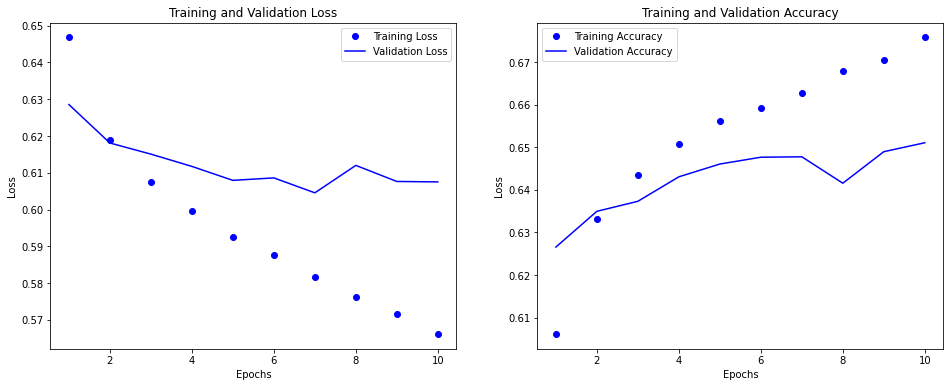

In [161]:
# 시각화
import matplotlib.pyplot as plt

acc2 = lstm_model2_history.history['accuracy']
val_acc2 = lstm_model2_history.history['val_accuracy']
loss2 = lstm_model2_history.history['loss']
val_loss2 = lstm_model2_history.history['val_loss']

epochs = range(1, len(acc2) + 1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss2, 'bo', label='Training Loss')
plt.plot(epochs, val_loss2, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()